In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import StratifiedShuffleSplit, LeaveOneOut, \
    learning_curve, train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, classification_report

from time import time

data = pd.read_csv("Data.csv")
data['Stroke(AIS,TIA,AHS)'] = 1

In [227]:
X_dropped = data.dropna().ix[:, :-1]
Y_dropped = data.dropna().ix[:, -1]

nulls = data.isnull().sum()
keys = nulls.keys()
values = nulls.values
words = [str(i)+". "+k.decode('utf-8').encode('ascii', 'ignore') for i, k in enumerate(nulls.keys())]

a = pd.DataFrame(values, keys)
indexes = a.loc[:].where(a < 50).dropna().index

data_chopped = data[indexes].dropna()
X_chopped = data_chopped.ix[:, :-1]
Y_chopped = data_chopped.ix[:, -1]

indexes_dropped = [str(i) + ". " + k.decode ('utf-8').encode('ascii', 'ignore') for i, k in enumerate(indexes)]

Xd_train, Xd_test, yd_train, yd_test = train_test_split( 
    X_dropped, Y_dropped, test_size = 0.2, random_state=1, stratify=Y_dropped)

Xc_train, Xc_test, yc_train, yc_test = train_test_split( 
    X_chopped, Y_chopped, test_size = 0.2, random_state=1, stratify=Y_chopped)

In [297]:
binarized = pd.get_dummies(data_chopped, columns=data_chopped.keys()[3:-1])

In [376]:
X_bin = binarized.drop(['DisNeuro01'], axis=1)
Y_bin = binarized['DisNeuro01']

Xb_train, Xb_test, yb_train, yb_test = train_test_split( 
    X_bin, Y_bin, test_size = 0.2, random_state=220, stratify=Y_bin)

In [417]:
binarized.head()

,"Stroke(AIS,TIA,AHS)",Sex01,StrokeAge,DisNeuro01,gFGB_0,gFGB_1,gFGB_2,gF2_0,gF2_1,gF5_0,...,gMTR:2756A>G_2.0,gMTRR:66A>G_0.0,gMTRR:66A>G_1.0,gMTRR:66A>G_2.0,gMTHFR677СT_0.0,gMTHFR677СT_1.0,gMTHFR677СT_2.0,gMTHFR:1298A>C_0.0,gMTHFR:1298A>C_1.0,gMTHFR:1298A>C_2.0
0,1,1,1.0,0,1,0,0,1,0,1,...,0,0,1,0,0,0,1,1,0,0
1,1,1,3.0,0,1,0,0,1,0,1,...,0,0,0,1,1,0,0,0,1,0
2,1,0,5.0,0,1,0,0,1,0,1,...,0,0,0,1,0,1,0,1,0,0
3,1,1,0.0,0,1,0,0,1,0,1,...,0,0,1,0,0,1,0,0,1,0
4,1,1,13.0,0,1,0,0,1,0,1,...,0,0,0,1,1,0,0,0,1,0


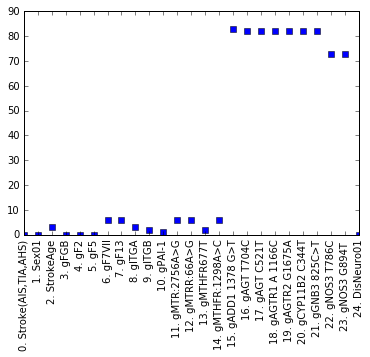

In [11]:
ind = np.arange(len(keys))
ax = plt.figure().add_subplot(111)
ax.set_xticks(ind)
ax.plot(values, 's')
xtickNames = ax.set_xticklabels(words)
plt.setp(xtickNames, rotation=90, fontsize=10)

plt.show()

In [10]:
data.groupby(['DisNeuro01', 'Sex01']).count()[['StrokeAge']]

StrokeAge
DisNeuro01 Sex01           
0          0             27
           1             54
1          0             26
           1             44

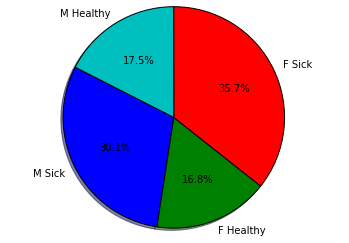

In [7]:
d = {
    'M Sick': 47, 
    'M Healthy': 26,
    'F Healthy': 27,
    'F Sick': 54,
    }
d_new = {
    'M Sick': 43, 
    'M Healthy': 25,
    'F Healthy': 24,
    'F Sick': 51,
    }
fig1, ax1 = plt.subplots()
ax1.pie(d_new.values(), labels=d_new.keys(), autopct='%1.1f%%',
        shadow=True, startangle=153)
ax1.axis('equal') 
plt.show()

In [70]:
data_chopped.shape

(143, 16)

In [9]:
# Мы исходим из предположения, что решающие деревья - это дич, а нижеследующее - просто чтобы было.
dt = tree.DecisionTreeClassifier()
dt = dt.fit(Xd_train, yd_train)
res = dt.predict(Xd_test)
print "Decision tree for dropped query:"
print classification_report(yd_test, res)
print accuracy_score(yd_test, res)

dt2 = tree.DecisionTreeClassifier()
dt2 = dt2.fit(Xc_train, yc_train)
res2 = dt2.predict(Xc_test)
print "Decision tree for chopped query:"
print classification_report(yc_test, res2)
print accuracy_score(yc_test, res2)

rf = RandomForestClassifier(random_state=1)
rf = rf.fit(Xd_train, yd_train)
res = rf.predict(Xd_test)
print "Random forest for dropped query:"
print classification_report(yd_test, res)
print accuracy_score(yd_test, res)

rf2 = RandomForestClassifier(random_state=1)
rf2 = rf2.fit(Xc_train, yc_train)
res2 = rf2.predict(Xc_test)
print "Random forest for chopped query:"
print classification_report(yc_test, res2)
print accuracy_score(yc_test, res2)

Очевидно, результат на данных с меньшим числом признаков лучше, чем на данных со всеми признаками.
Попробуем в случайный лес.

             precision    recall  f1-score   support

          0       0.50      0.75      0.60         8
          1       0.33      0.14      0.20         7

avg / total       0.42      0.47      0.41        15

0.466666666667


In [15]:
def learning_curve_model(X, Y, model, cv, train_sizes):
    """Функция строит кривую обучения"""
    plt.figure(figsize=(10, 6))
    plt.title("Learning curve")
    plt.xlabel("Training examples")
    plt.ylabel("Score")


    train_sizes, train_scores, test_scores = learning_curve(model, X, Y, cv=cv, n_jobs=4, train_sizes=train_sizes)

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std  = np.std(train_scores, axis=1)
    test_scores_mean  = np.mean(test_scores, axis=1)
    test_scores_std   = np.std(test_scores, axis=1)
    plt.grid()
    
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,test_scores_mean + test_scores_std, alpha=0.1, color="b")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="b",label="Cross-validation score")
                     
    plt.legend(loc="best")
    return plt

In [405]:
loo = LeaveOneOut()

start=time()

param_grid = {
    "n_estimators": [5, 10, 15, 20],
     "criterion": ["entropy"],
     "max_features": [3, 10, "sqrt"],
     "max_depth": [1, 3, 5],
     "bootstrap": [True, False],
             }
tuned_forest = GridSearchCV(RandomForestClassifier(), param_grid, cv=loo, n_jobs=-1)
tuned_forest.fit(Xb_train, yb_train)

print "Taken time:", time()-start
print "Best params: ", tuned_forest.best_params_

Taken time: 468.624593973
Best params:  {'max_features': 10, 'n_estimators': 10, 'bootstrap': True, 'criterion': 'entropy', 'max_depth': 5}


             precision    recall  f1-score   support

          0       0.65      0.87      0.74        15
          1       0.78      0.50      0.61        14

avg / total       0.71      0.69      0.68        29

0.689655172414


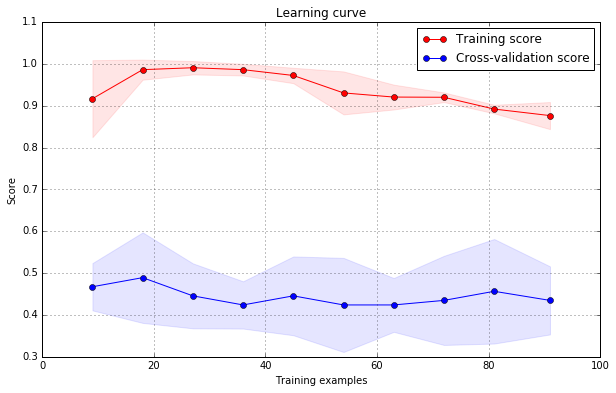

In [415]:
rf_tuned = RandomForestClassifier(n_estimators=10, max_features=10,
                                  max_depth=5, criterion='entropy', 
                                  bootstrap=True, random_state=1)
rf_tuned.fit(Xb_train, yb_train)
res_tuned = rf_tuned.predict(Xb_test)
print classification_report(yb_test, res_tuned)
print accuracy_score(yb_test, res_tuned)

cv = StratifiedShuffleSplit(n_splits=4, test_size=0.2, random_state=1142)
learning_curve_model(Xb_train, yb_train, rf_tuned, cv, np.linspace(0.1, 1.0, 10))
plt.show()

In [410]:
loo = LeaveOneOut()

start=time()

param_grid = {
     "alpha": [1e-6, 1e-5, 1e-4],
     "max_iter": [25, 50, 100],
     "hidden_layer_sizes": [[i, j] for i in range(1, 10) for j in range(1, 4)],
             }
tuned_nn = GridSearchCV(MLPClassifier(), param_grid, cv=loo, n_jobs=-1)
tuned_nn.fit(Xb_train, yb_train)

print "Taken time:", time()-start
print "Best params: ", tuned_forest.best_params_

Taken time: 925.896449089
Best params:  {'max_features': 10, 'n_estimators': 10, 'bootstrap': True, 'criterion': 'entropy', 'max_depth': 5}


In [411]:
print "Best params: ", tuned_nn.best_params_

Best params:  {'alpha': 1e-05, 'max_iter': 100, 'hidden_layer_sizes': [4, 2]}


             precision    recall  f1-score   support

          0       0.77      0.67      0.71        15
          1       0.69      0.79      0.73        14

avg / total       0.73      0.72      0.72        29

0.724137931034


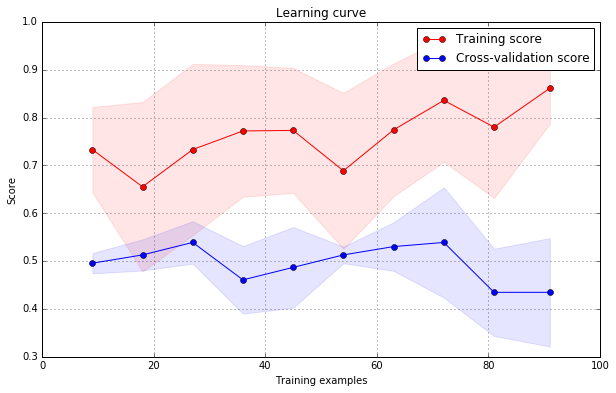

In [413]:
nn = MLPClassifier(solver='lbfgs', alpha=1e-5, max_iter=50,
                    hidden_layer_sizes=[4,  2], random_state=1)
nn.fit(Xb_train, yb_train)

nn_res = nn.predict(Xb_test)
print classification_report(yb_test, nn_res)
print accuracy_score(yb_test, nn_res)

cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=1)
learning_curve_model(Xb_train, yb_train, nn, cv, np.linspace(0.1, 1.0, 10))
plt.show()

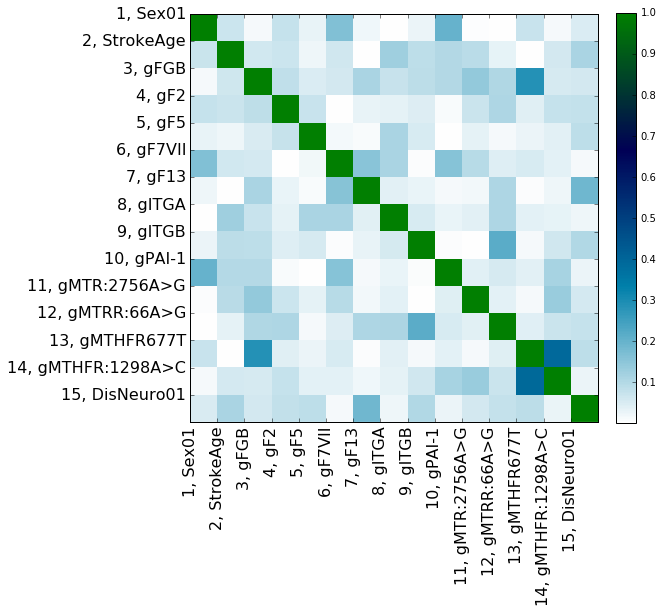

In [223]:
data_chopped.corr().abs()
figure = plt.figure(figsize=(8, 8))
ax = figure.add_subplot(111)

xtickNames = ax.set_xticklabels(indexes_dropped[1:])
plt.setp(xtickNames, rotation=90, fontsize=16)
xtickNames = ax.set_yticklabels(indexes_dropped[1:])
plt.setp(xtickNames, fontsize=16)

ax.set_xticks(range(15))
ax.set_yticks(range(15))
# cmap = 'Blues', "ocean", "Set1" is ok
cax = ax.imshow(data_chopped.ix[:, 1:].corr().abs(), extent=[0,15,15,0], interpolation='none', cmap='ocean_r')
cbar = figure.colorbar(cax, fraction=0.046, pad=0.04)

plt.show()

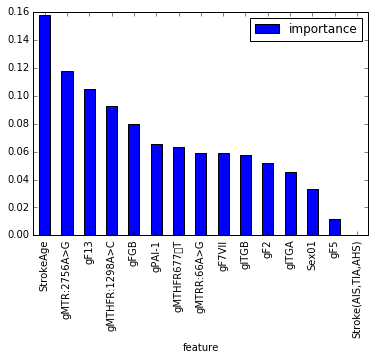

In [419]:
importances = pd.DataFrame({'feature':Xc_train.columns,'importance':rf_tuned.feature_importances_})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
importances.plot.bar(color='b')
plt.show()

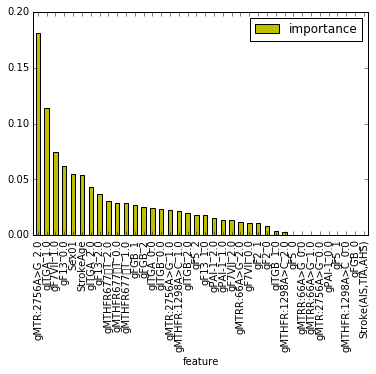

In [328]:
importances = pd.DataFrame({'feature':Xb_train.columns,'importance':rf_tuned.feature_importances_})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
importances.plot.bar(color='y')
plt.show()